# Kaggle: House Prices

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## XGBoost Regression

* XGBoost model with hyperparameter tuning.
* Log-transform of dependent variable.

In [1]:
import warnings
import json
import copy
import numpy as np
import pandas as pd

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
import preprocess

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_train = preprocess.preprocess(df_train)

features = list(df_train.columns)
features.remove('SalePrice')
features.remove('Id')

df_test = pd.read_csv('./data/test.csv')
df_test = preprocess.preprocess(df_test, columns_needed=features)

Columns {'Heating_OthW', 'RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal', 'Electrical_Mix', 'HouseStyle_2.5Fin', 'MiscFeature_TenC', 'RoofMatl_Roll', 'ExteriorOther', 'Heating_Floor'} are missing, adding them.


In [4]:
import xgboost as xgb

# Log transform variable (this will ensure that final output will always be positive.)
y_train = np.log(df_train['SalePrice']).values.reshape(-1, 1)
print('y_train: ', y_train.shape)

x_train = df_train[features].values
print('x_train: ', x_train.shape)

dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(x_train, label=y_train)

y_train:  (1460, 1)
x_train:  (1460, 250)


In [5]:
# Hyperparameter turning with cross-validation
from sklearn.model_selection import ParameterGrid

num_boost_round = 999
early_stopping_rounds = 25

# XGBoost parameters explained: https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
params = {
    # Parameters to tune
    'max_depth': 2,  # Maximum depth of a tree
    'min_child_weight': 1,  # Minimum number of instances needed to be in each node
    'eta': .2,  # Learning_rate (shrinks the feature weights to make the boosting process more conservative)
    'subsample': 1,  # Subsample ratio of the training instance
    'colsample_bytree': 1,  # Subsample ratio of columns
    'lambda': 0,  # L2 regularization term
    'alpha': 0,  # L1 regularization term
    'gamma': 0,  # Minimum loss reduction required to make a further partition
    # Other params
    'objective': 'reg:linear',
    'eval_metric': 'rmse'
}

# Search parameters for hyperparameter tuning
param_searches = [
    {'eta': [.3, .2, .15, .1, .05, .01]},
    {'max_depth': [1, 2, 3, 5], 'min_child_weight': [0, 0.1, 0.5, 1, 2, 3, 5]},
    {'subsample': [0.7, 0.8, 0.9, 0.95, 0.99, 1.]},
    {'colsample_bytree': [0.7, 0.8, 0.9, 0.95, 1.]},
    {'gamma': [0.0, 0.1, 0.2, 0.3, 0.5, 1.]},
    {'lambda': [0.0, 1e-5, 1e-2, 0.1, 1, 10, 100, 1000]},
    {'alpha': [0.0, 1e-5, 1e-2, 0.1, 1, 100]}
]

# Perform hyperparameter tuning
best_params = copy.deepcopy(params)
min_error = float('Inf')
for psearch in param_searches:
    p_best = None
    p_combinations = list(ParameterGrid(psearch))
    print('\nTesting {} combinations for {}'.format(len(p_combinations), list(p_combinations[0].keys())))
    for p_new in p_combinations:
        # Update training params
        params.update(p_new)
        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics={'rmse'},
            early_stopping_rounds=early_stopping_rounds
        )
        new_error = cv_results['test-rmse-mean'].min()
        if new_error < min_error:
            min_error = new_error
            print('New best error found: {}'.format(min_error))
            best_params.update(p_new)
            p_best = p_new
    params.update(best_params)
    print('Min_error: {} for {}'.format(min_error, p_best))

params.update(best_params)
print('Best params: ', json.dumps(params, indent=4, sort_keys=True))


Testing 6 combinations for ['eta']
New best error found: 0.1384968
New best error found: 0.134949
New best error found: 0.13437159999999998
New best error found: 0.1333582
Min_error: 0.1333582 for {'eta': 0.1}

Testing 28 combinations for ['max_depth', 'min_child_weight']
New best error found: 0.13288819999999998
New best error found: 0.132095
New best error found: 0.13200399999999998
New best error found: 0.1312376
Min_error: 0.1312376 for {'max_depth': 3, 'min_child_weight': 3}

Testing 6 combinations for ['subsample']
New best error found: 0.1308102
New best error found: 0.12963940000000002
Min_error: 0.12963940000000002 for {'subsample': 0.9}

Testing 5 combinations for ['colsample_bytree']
New best error found: 0.1295778
Min_error: 0.1295778 for {'colsample_bytree': 0.7}

Testing 6 combinations for ['gamma']
Min_error: 0.1295778 for None

Testing 8 combinations for ['lambda']
New best error found: 0.1288088
New best error found: 0.1259736
Min_error: 0.1259736 for {'lambda': 10}



In [6]:
# Find the best possible number of iterations and train final model

# Find best number of iterations
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=early_stopping_rounds
)
print('Best rmse error: ', cv_results['test-rmse-mean'].min())
boost_rounds = cv_results['test-rmse-mean'].argmin()
print('Best number of boost_rounds: ', boost_rounds)

# Train final model
model = xgb.train(
    params=params, 
    dtrain=dtrain, 
    num_boost_round=boost_rounds
)

Best rmse error:  0.1259736
Best number of boost_rounds:  287


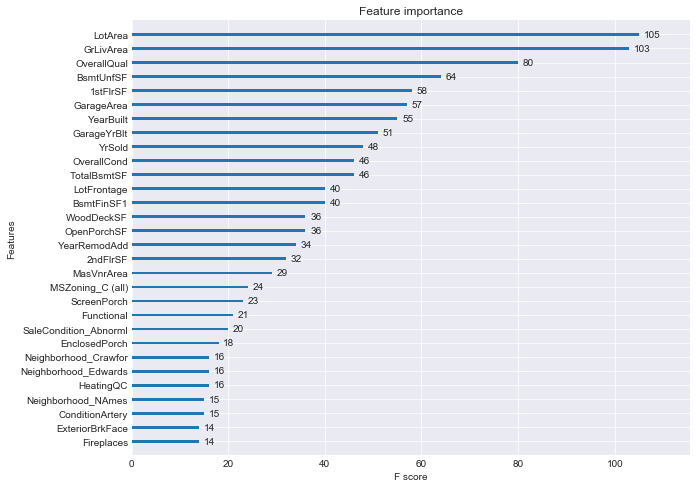

In [7]:
# Show feature importances
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
xgb.plot_importance(model, ax=ax, max_num_features=30)
plt.show()

y_train_pred:  (1460,)
Mean squared error: 178745741.4563981
Variance score: 0.9716581998845458


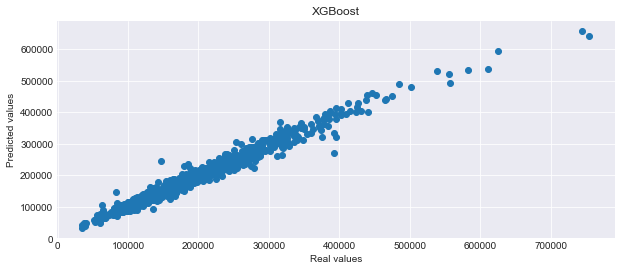

In [8]:
# Predictions from train set
from sklearn.metrics import mean_squared_error, r2_score

y_train_pred = np.exp(model.predict(dtrain))
print('y_train_pred: ', y_train_pred.shape)

print('Mean squared error: {}'.format(mean_squared_error(df_train['SalePrice'], y_train_pred)))
print('Variance score: {}'.format(r2_score(df_train['SalePrice'], y_train_pred)))


# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(df_train['SalePrice'], y_train_pred)
plt.title('XGBoost')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

x_test:  (1459, 250)
y_test_pred:  (1459,)
0 values above 800k


,Id,SalePrice
0,1461,119849.796875
...,...,...
1458,2919,227276.875000


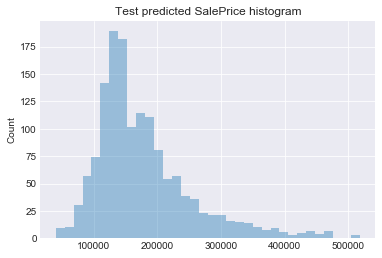

In [9]:
# Make predictions on test set and save the results
# This gets an error of 0.12647 on the leaderboard. 
x_test = df_test[features].values
print('x_test: ', x_test.shape)

dtest = xgb.DMatrix(x_test, feature_names=features)

y_test_pred = np.exp(model.predict(dtest))
print('y_test_pred: ', y_test_pred.shape)

# Test for negative and infinity values:
assert (y_test_pred >= 0).all()
assert not np.isinf(y_test_pred).any(), '{} infinity values '.format(sum(np.isinf(y_test_pred)))
print('{} values above 800k'.format(sum(y_test_pred >= 800000)))

df_test_predict = df_test[['Id']]
df_test_predict['SalePrice'] = np.squeeze(y_test_pred)
assert df_test_predict.notnull().all().all()

with pd.option_context('display.max_rows', 3, 'display.max_columns', 2):
    display(df_test_predict)
    
df_test_predict.to_csv('output_xgboost.csv', index=False)

sns.distplot(np.squeeze(y_test_pred), hist=True, kde=False, norm_hist=False)
plt.title('Test predicted SalePrice histogram')
plt.ylabel('Count')
plt.show()